### Auto MPG prediction project
(**Dataset:** http://archive.ics.uci.edu/ml/datasets/Auto+MPG)

**Problem statement:** The data contains the MPG (Mile Per Gallon) variable which is continuous data and tells us about the efficiency of fuel consumption of a vehicle in the 70s and 80s.

**_Our aim here is to predict the MPG value for a vehicle, given that we have other attributes of that vehicle._**

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import pickle

### Load data 

In [2]:
# defining the column names - we can get it from the website where the dataset is available
cols = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

# reading the .data file using pandas
df = pd.read_csv('data/auto-mpg.data', names=cols, na_values = "?",
                comment = '\t',
                sep= " ",
                skipinitialspace=True)
#making a copy of the dataframe
data = df.copy()
data

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### Exploratory Data Analysis

In [3]:
#First, check the datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [4]:
#Cheking, whether there are some missing values
data.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

**We have to take a closer look on the 'Horsepower' column**

In [5]:
#general statistical info about horsepower
data['Horsepower'].describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: Horsepower, dtype: float64

<AxesSubplot:xlabel='Horsepower'>

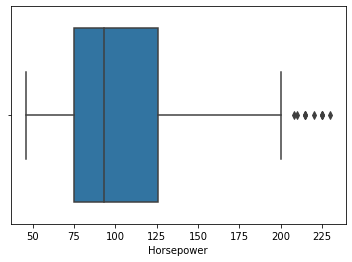

In [6]:
#Cheking possible outliers
sns.boxplot(x=data['Horsepower'])

We can identify a couple of outliers, therefore I will remove those first, then calculate the median in order to fill the missing values.

In [7]:
data = data.drop(data[(data['Horsepower']>200)].index)

In [8]:
median = data['Horsepower'].median()
data['Horsepower'] = data['Horsepower'].fillna(median)
data.isnull().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

**We have two categorical variables, "Origin" and "Cylinders"**

4    0.525773
8    0.239691
6    0.216495
3    0.010309
5    0.007732
Name: Cylinders, dtype: float64


<AxesSubplot:>

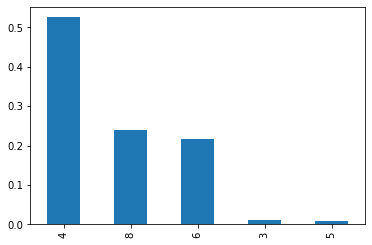

In [9]:
#distribution
cylinders = data['Cylinders'].value_counts() / len(data)
print(cylinders)
cylinders.plot.bar()

1    0.615979
3    0.203608
2    0.180412
Name: Origin, dtype: float64


<AxesSubplot:>

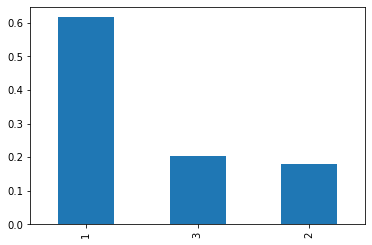

In [10]:
origin = data['Origin'].value_counts() / len(data)
print(origin)
origin.plot.bar()

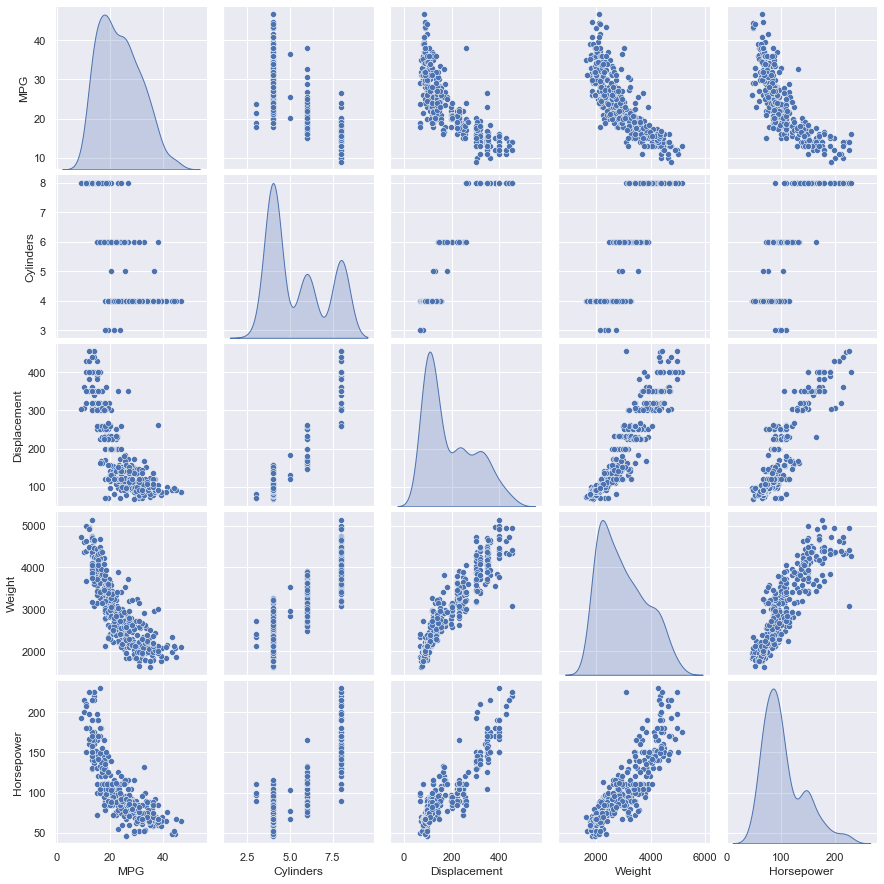

In [11]:
#Checking correlations
sns.set()
cols = ["MPG", "Cylinders", "Displacement", "Weight", "Horsepower"]
sns.pairplot(df[cols], height = 2.5,diag_kind="kde")
plt.show()

We can get a brief overview of how each variable behaves with respect to every other variables in the dataset.
Examples:
* MPG our target variable is negatively correlated with the displacement, horsepower and weight variables
* Displacement and Weight has a linear correlation
* Also there is a linear correlation betwwen Weight and Horsepower 

* Column **Origin** is categorical, however, has discrete values. Therefore I will rename and convert those to strings.

In [12]:
data['Origin'] = data['Origin'].map({1: 'India', 2: 'USA', 3:'Germany'})
data.sample(10)

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
39,14.0,8,400.0,175.0,4464.0,11.5,71,India
364,26.6,8,350.0,105.0,3725.0,19.0,81,India
378,38.0,4,105.0,63.0,2125.0,14.7,82,India
97,18.0,6,225.0,105.0,3121.0,16.5,73,India
317,34.3,4,97.0,78.0,2188.0,15.8,80,USA
380,36.0,4,120.0,88.0,2160.0,14.5,82,Germany
111,18.0,3,70.0,90.0,2124.0,13.5,73,Germany
146,28.0,4,90.0,75.0,2125.0,14.5,74,India
185,26.0,4,98.0,79.0,2255.0,17.7,76,India
383,38.0,4,91.0,67.0,1965.0,15.0,82,Germany


In [13]:
data = pd.get_dummies(data)
data.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_Germany,Origin_India,Origin_USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,1,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,1,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,1,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,1,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,1,0


**Adding new variables to improve our model**

In [14]:
data['acceleration_on_power'] = data['Acceleration'] / data['Horsepower']
data['acceleration_on_cyl'] = data['Acceleration'] / data['Cylinders']
corr_matrix = data.corr()
corr_matrix['MPG'].sort_values(ascending=False)

MPG                      1.000000
acceleration_on_cyl      0.718759
acceleration_on_power    0.688885
Model Year               0.559825
Origin_Germany           0.436919
Acceleration             0.388729
Origin_USA               0.249688
Origin_India            -0.559154
Cylinders               -0.763671
Horsepower              -0.783456
Displacement            -0.800157
Weight                  -0.825125
Name: MPG, dtype: float64

#### _Acceleration_on_power_ and _acceleration_on_cyl_ as two new variables which turned out to be more positively correlated than the original variables.

### Split the data to train and validation set

In [15]:
train_set, val_set = train_test_split(data, test_size=0.2, random_state=42)

In [16]:
print(train_set.shape)
print(val_set.shape)

(310, 12)
(78, 12)


In this case, instead of using the most popular _train_test_split()_ method, I wil use **stratified sampling** to create homogeneous train and validation set.

In [17]:
data = data.reset_index() #neccesary due to the outlier removal
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=12)
for train_index, val_index in split.split(data, data["Cylinders"]):
    strat_train_set = data.loc[train_index]
    strat_val_set = data.loc[val_index]
strat_train_set = strat_train_set.drop(['index'],1)
strat_val_set = strat_val_set.drop(['index'],1)

In [18]:
print(strat_train_set.shape)
print(strat_val_set.shape)

(310, 12)
(78, 12)


#### We can try out both implementations and compare the results, in order to find which oen works better.

### Make life easier!!!! - above mentioned steps can be implemented in functions, than we can apply those with few lines of code. Let's take a look on the implementation!

In [19]:
# defining the column names - we can get it from the website where the dataset is available
cols = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

# reading the .data file using pandas
df = pd.read_csv('data/auto-mpg.data', names=cols, na_values = "?",
                comment = '\t',
                sep= " ",
                skipinitialspace=True)
#making a copy of the dataframe
data = df.copy()
data

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


In [20]:
#remove outliers
def remove_outliers(df):
    df = df.drop(df[(df['Horsepower']>200)].index)
    return df

In [21]:
data = remove_outliers(data)

In [22]:
#split train and validation set
data.reset_index(inplace=True, drop=True)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in split.split(data, data["Cylinders"]):
    strat_train_set = data.loc[train_index]
    strat_val_set = data.loc[val_index]

In [23]:
#separate target variable and predictive variables
data = strat_train_set.drop("MPG", axis=1)
data_labels = strat_train_set["MPG"].copy()
data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
224,4,151.0,88.0,2740.0,16.0,77,1
96,8,360.0,170.0,4654.0,13.0,73,1
138,4,116.0,75.0,2246.0,14.0,74,2
237,4,85.0,70.0,2070.0,18.6,78,3
307,4,97.0,78.0,2188.0,15.8,80,2
...,...,...,...,...,...,...,...
131,4,98.0,83.0,2219.0,16.5,74,2
375,4,91.0,67.0,1995.0,16.2,82,3
145,6,250.0,72.0,3158.0,19.5,75,1
83,8,429.0,198.0,4952.0,11.5,73,1


* preprocess the Origin column in data

In [24]:
def preprocess_origin_cols(df):
    df["Origin"] = df["Origin"].map({1: "India", 2: "USA", 3: "Germany"})
    return df

* creating custom attribute adder class

In [25]:
acceleration_index, horsepower_index, cylinders_index = 4,2, 0

class CustomAttrAdder(BaseEstimator, TransformerMixin):
    def __init__(self, acc_on_power=True): # no *args or **kargs
        self.acc_on_power = acc_on_power
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        acc_on_cyl = X[:, acceleration_index] / X[:, cylinders_index]
        if self.acc_on_power:
            acc_on_power = X[:, acceleration_index] / X[:, horsepower_index]
            return np.c_[X, acc_on_power, acc_on_cyl]
        
        return np.c_[X, acc_on_cyl]

* pipeline functions

In [26]:
def num_pipeline_transformer(data):
    '''
    Function to process numerical transformations
    Argument:
        data: original dataframe 
    Returns:
        num_attrs: numerical dataframe
        num_pipeline: numerical pipeline object
        
    '''
    numerics = ['float64', 'int64']

    num_attrs = data.select_dtypes(include=numerics)

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attrs_adder', CustomAttrAdder()),
        ('std_scaler', StandardScaler()),
        ])
    return num_attrs, num_pipeline


def pipeline_transformer(data):
    '''
    Complete transformation pipeline for both
    nuerical and categorical data.
    
    Argument:
        data: original dataframe 
    Returns:
        prepared_data: transformed data, ready to use
    '''
    cat_attrs = ["Origin"]
    num_attrs, num_pipeline = num_pipeline_transformer(data)
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, list(num_attrs)),
        ("cat", OneHotEncoder(), cat_attrs),
        ])
    prepared_data = full_pipeline.fit_transform(data)
    return prepared_data

In [27]:
preprocessed_df = preprocess_origin_cols(data)
prepared_data = pipeline_transformer(preprocessed_df)
prepared_data[0]

array([-0.83204683, -0.37265824, -0.39044074, -0.25419717,  0.08394617,
        0.24620712,  0.04491349,  0.63869118,  0.        ,  1.        ,
        0.        ])

In [28]:
prepared_data.shape

(310, 11)

In [29]:
data_labels.shape

(310,)

### Model selection

Using **Mean Squared Error** for validation and also for better results **Cross Validation**.

* Random Forest

In [30]:
forest_reg = RandomForestRegressor()
forest_reg.fit(prepared_data, data_labels)
forest_reg_cv_scores = cross_val_score(forest_reg,
                                         prepared_data,
                                         data_labels,
                                         scoring='neg_mean_squared_error',
                                         cv = 10)

forest_reg_rmse_scores = np.sqrt(-forest_reg_cv_scores)
forest_reg_rmse_scores.mean()

2.5838167708901976

* Support Vector Machine Regressor

In [31]:
svm_reg = SVR(kernel='linear')
svm_reg.fit(prepared_data, data_labels)
svm_cv_scores = cross_val_score(svm_reg, prepared_data, data_labels,
                                scoring='neg_mean_squared_error',
                                cv = 10)
svm_rmse_scores = np.sqrt(-svm_cv_scores)
svm_rmse_scores.mean()

3.029514401755359

* **Hyperparameter tuning with GridSearch on RandomForest**

In [32]:
param_grid = [
    {'n_estimators': [3, 10, 30],
     'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False],
     'n_estimators': [3, 10],
     'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid,
                           scoring='neg_mean_squared_error',
                           return_train_score=True,
                           cv=10,
                          )

grid_search.fit(prepared_data, data_labels)

GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [33]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [34]:
#cheking all the results with scores
cv_scores = grid_search.cv_results_
for mean_score, params in zip(cv_scores['mean_test_score'], cv_scores["params"]):
    print(np.sqrt(-mean_score), params)

3.385828572956408 {'max_features': 2, 'n_estimators': 3}
3.1567228310794193 {'max_features': 2, 'n_estimators': 10}
2.871738074736704 {'max_features': 2, 'n_estimators': 30}
3.1984444023590712 {'max_features': 4, 'n_estimators': 3}
2.8279867454176766 {'max_features': 4, 'n_estimators': 10}
2.798983257539363 {'max_features': 4, 'n_estimators': 30}
3.027314719120255 {'max_features': 6, 'n_estimators': 3}
2.845201393177983 {'max_features': 6, 'n_estimators': 10}
2.7471077263578603 {'max_features': 6, 'n_estimators': 30}
3.013008832085001 {'max_features': 8, 'n_estimators': 3}
2.8644109905145676 {'max_features': 8, 'n_estimators': 10}
2.767480642017691 {'max_features': 8, 'n_estimators': 30}
3.190903850559046 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
2.9490883227675413 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
3.257309398280893 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
2.894365215379704 {'bootstrap': False, 'max_features': 3, 'n_estimator

* **Cheking feature importance in the model** 

In [35]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attrs = ["acc_on_power", "acc_on_cyl"]
numerics = ['float64', 'int64']
num_attrs = list(data.select_dtypes(include=numerics))

attrs = num_attrs + extra_attrs
sorted(zip(attrs, feature_importances), reverse=True)

[('acc_on_power', 0.04272515621759596),
 ('acc_on_cyl', 0.07765871922307341),
 ('Weight', 0.15483349889690814),
 ('Model Year', 0.11556106019199038),
 ('Horsepower', 0.13546393438677198),
 ('Displacement', 0.27089426416066137),
 ('Cylinders', 0.17642441396078962),
 ('Acceleration', 0.01621029144907927)]

### Evaluation on the validation data

In [36]:
final_model = grid_search.best_estimator_
X_test = strat_val_set.drop("MPG", axis=1)
y_test = strat_val_set["MPG"].copy()
X_test_preprocessed = preprocess_origin_cols(X_test)
X_test_prepared = pipeline_transformer(X_test_preprocessed)
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [37]:
final_rmse

3.1777829179326074

In [38]:
#function for prediction, where the input should be a dictionary
def predict_mpg(config, model):
    
    if type(config) == dict:
        df = pd.DataFrame(config)
    else:
        df = config
    
    preproc_df = preprocess_origin_cols(df)
    prepared_df = pipeline_transformer(preproc_df)
    y_pred = model.predict(prepared_df)
    return y_pred

In [39]:
#save our final model
with open("final_model_mpg_prediction.bin", 'wb') as f_out:
    pickle.dump(final_model, f_out)
    f_out.close()

### Try out our saved model
(just to double check!)

In [40]:
##vehicle config
vehicle_config = {
    'Cylinders': [4, 6, 8],
    'Displacement': [155.0, 160.0, 165.5],
    'Horsepower': [93.0, 130.0, 98.0],
    'Weight': [2500.0, 3150.0, 2600.0],
    'Acceleration': [15.0, 14.0, 16.0],
    'Model Year': [81, 80, 78],
    'Origin': [3, 2, 1]
}

In [41]:
##loading the model from the saved file
with open('final_model_mpg_prediction.bin', 'rb') as f_in:
    model = pickle.load(f_in)

In [42]:
predict_mpg(vehicle_config, model)

array([32.87666667, 18.59666667, 20.79333333])